In [1]:
import numpy as np
from matplotlib import pyplot, cm
%matplotlib inline

from tqdm import tqdm
import time

import sys
np.set_printoptions(threshold=sys.maxsize)

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [2]:
g0=4     #Bacterial growth Parameter
gamma=16     #Bacterial growth Parameter
k_value=42.5     #Bacterial growth Parameter

Dc=1e-3
Db=.21

t_ref=20
Xe_value=.3

X0=1e-3

C0=15
C_thresh_value=1.5

d=20 #separation between inoculum change; check for 5mm, 10mm, 20mm
rho=2.5
mu=40

dx=dy = 0.25

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


Current time is: Sun Nov  3 15:08:30 2019


In [3]:
X1=np.zeros((369,369),dtype=np.float64)   # 2-D array 
X2=np.zeros((369,369),dtype=np.float64)
C=np.zeros((369,369),dtype=np.float64)
m=np.zeros((369,369))
Xe=np.zeros((369,369))
C_thresh=np.zeros((369,369))
k=np.zeros((369,369))

#(taking x,y for coordinate positions) :
x=np.linspace(-184,184,num=369,dtype=int)
y=np.linspace(-184,184,num=369,dtype=int)
 
############# Defining Initial Conditions #############
# for X1 and X2
for i in range(len(x)):
    for j in range(len(y)):
        if  ((x[i]-d/2)**2 + y[j]**2 <= rho**2):
            X1[i,j] = X0
        
        if  (x[i]+d/2)**2 + y[j]**2 <= rho**2:
            X2[i,j] = X0


                                                                       #np.savetxt('output.txt',X1,fmt='%.4e')

#Initializing parameters in array for all positional coordinates on 2D grid:
for i in range(len(x)):
    for j in range(len(y)):
        C[i,j]=C0
        C_thresh[i,j]=C_thresh_value
        Xe[i,j]=Xe_value
        k[i,j]=k_value

X1_hist=np.zeros((500,369,369))
X2_hist=np.zeros((500,369,369))
C_hist=np.zeros((500,369,369))

X1_hist[0][:][:]=X1[:][:]
X2_hist[0][:][:]=X2[:][:]
C_hist[0][:][:]=C[:][:]

print("Initializing Initial Conditions has been completed")
#######################################################        
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

Initializing Initial Conditions has been completed
Current time is: Sun Nov  3 15:08:35 2019


In [4]:
def H_t(var,value):        # heavy side step function for time, not for matrix output
    if var-value <0:
        return 0
    if var-value==0:
        return 0.5
    else: return 1

    
def H_pos(mat1,mat2):      # heavy side step function for position, for matrix output H(Xe,X1+X2)
    
    mat3=np.zeros((max(mat1.shape),min(mat1.shape)))
    for i in range(max(mat1.shape)):
        for j in range(min(mat1.shape)):
            if mat1[i,j]-mat2[i,j]<0:
                mat3[i,j]=0
            if mat1[i,j]-mat2[i,j]==0:
                mat3[i,j]=0.5
            else: mat3[i,j]=1
  
    return mat3
       

def growth(nt,time_length):  # to be given number of time steps
    
    # nt : number of time-steps -- to be made 5001
    # time_length in hours: duration of time upto which you wish to see the simulation --- to be made 48 hours

    dt=time_length/nt       # time-step size
    print("The growth for time by time step %f has been completed for:-" %dt)
    
    for n in range(nt):
        
        g_c=g0*np.divide(C,np.add(k,C))
        
        m[:,:]=mu*np.multiply(np.multiply(X1[:,:],X2[:,:]),H_pos(Xe,X1+X2))*H_t((n-1)*dt,t_ref)
        X1[1:-1,1:-1]=X1[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X1[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X1[2:,1:-1]-2*X1[1:-1,1:-1]+X1[:-2,1:-1])/dx**2) + ((X1[1:-1,2:]-2*X1[1:-1,1:-1]+X1[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        X2[1:-1,1:-1]=X2[1:-1,1:-1]+dt*((np.multiply(g_c[1:-1,1:-1],X2[1:-1,1:-1]))+Db*np.multiply(H_pos(C[1:-1,1:-1],C_thresh[1:-1,1:-1]),(((X2[2:,1:-1]-2*X2[1:-1,1:-1]+X2[:-2,1:-1])/dx**2) + ((X2[1:-1,2:]-2*X2[1:-1,1:-1]+X2[1:-1,:-2])/dy**2))) - m[1:-1,1:-1])
        
        C[1:-1,1:-1]= C[1:-1,1:-1] +dt*(-gamma*(np.multiply(g_c[1:-1,1:-1],np.add(X1[1:-1,1:-1],X2[1:-1,1:-1]))) + Dc*(((C[2:,1:-1]-2*C[1:-1,1:-1]+C[:-2,1:-1])/dx**2) + ((C[1:-1,2:]-2*C[1:-1,1:-1]+C[1:-1,:-2])/dy**2)))

        ############# Start: Boundary Conditions ######################
        
        #Neumann Condition: Normal component of Bacterial density on boundary is zero
        
        X1[:][-1] = X1[:][-2]
        X1[:][0]  = X1[:][1] 
        X1[-1][:] = X1[-2][:]
        X1[0][:]  = X1[1][:] 

        
                            # not sure whether it is a right way of doing. Perhaps, it should be opposite way as above calculation stencil never go on edge, so it would remain X0 eternally. But, it should change
        X2[:][-1] = X2[:][-2]
        X2[:][0]  = X2[:][1] 
        X2[-1][:] = X2[-2][:]
        X2[0][:]  = X2[1][:] 

        
        
        #Dirichlet condition: Fixed and Unchanging Concentration of growth media on boundary
        C[0][:]=C[-1][:]=C[:][0]=C[:][-1]=C0
        
        ############# End: Boundary Conditions ######################

        ############ Start: Saving history of Bacterial Density and Growth Media Concentration #########
        
        X1_hist[n+1][:][:]=X1[:][:]
        X2_hist[n+1][:][:]=X2[:][:]
        C_hist[n+1][:][:]=C[:][:]
        
        ############ End: Saving history of Bacterial Density and Growth Media Concentration #########
        
      
        print("%d steps, Wall clock time: "  %n, end="")
        
        print(time.asctime( time.localtime(time.time())))
        
nt=20
time_length=.09

growth(nt,time_length)

print("All the step calculations for growth have been completed")  

The growth for time by time step 0.004500 has been completed for:-
0 steps, Wall clock time: Sun Nov  3 15:08:37 2019
1 steps, Wall clock time: Sun Nov  3 15:08:40 2019
2 steps, Wall clock time: Sun Nov  3 15:08:43 2019
3 steps, Wall clock time: Sun Nov  3 15:08:45 2019
4 steps, Wall clock time: Sun Nov  3 15:08:46 2019
5 steps, Wall clock time: Sun Nov  3 15:08:47 2019
6 steps, Wall clock time: Sun Nov  3 15:08:49 2019
7 steps, Wall clock time: Sun Nov  3 15:08:51 2019
8 steps, Wall clock time: Sun Nov  3 15:08:53 2019
9 steps, Wall clock time: Sun Nov  3 15:08:56 2019
10 steps, Wall clock time: Sun Nov  3 15:08:58 2019
11 steps, Wall clock time: Sun Nov  3 15:09:01 2019
12 steps, Wall clock time: Sun Nov  3 15:09:03 2019
13 steps, Wall clock time: Sun Nov  3 15:09:05 2019
14 steps, Wall clock time: Sun Nov  3 15:09:08 2019
15 steps, Wall clock time: Sun Nov  3 15:09:10 2019
16 steps, Wall clock time: Sun Nov  3 15:09:12 2019
17 steps, Wall clock time: Sun Nov  3 15:09:15 2019
18 step

Plotting figures for Nutrient Media Concentration
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Current time is: Sun Nov  3 15:09:54 2019


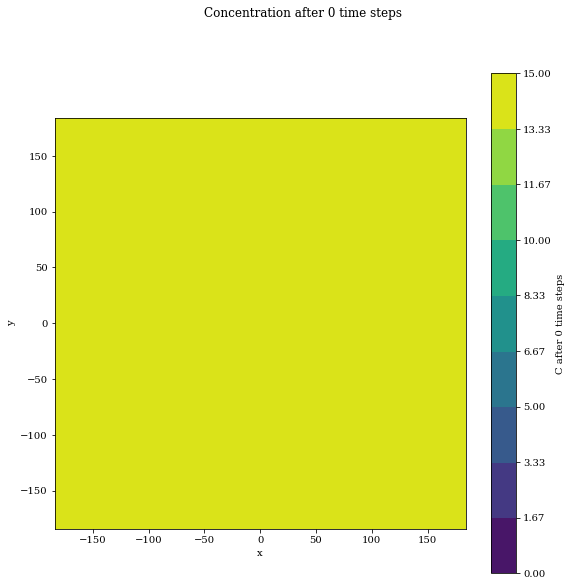

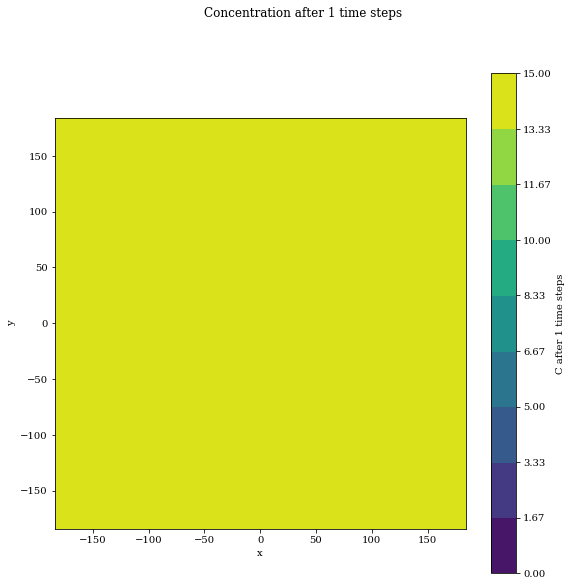

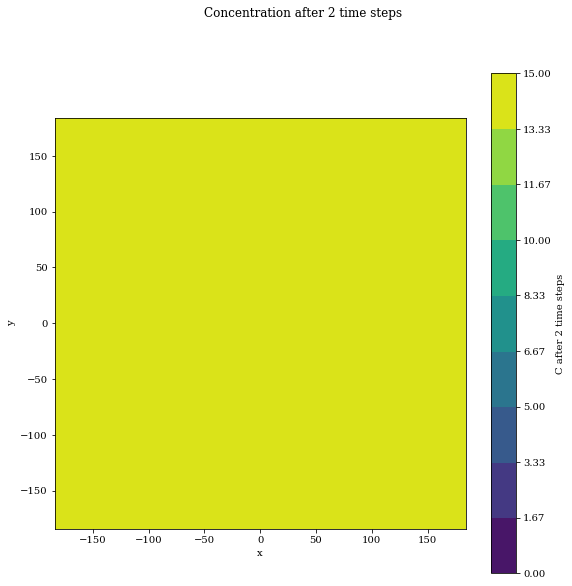

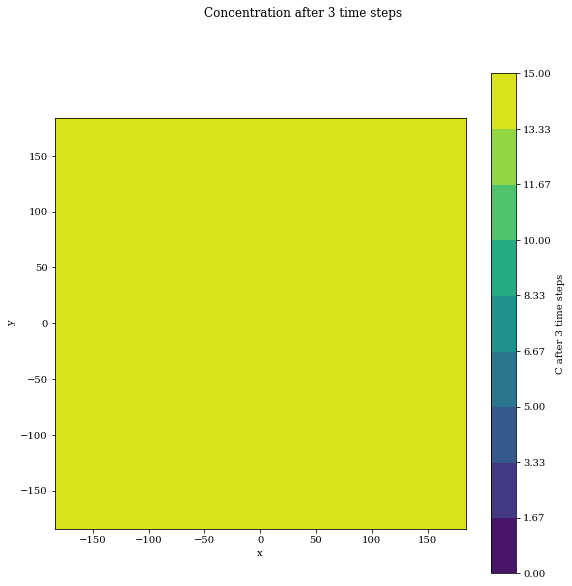

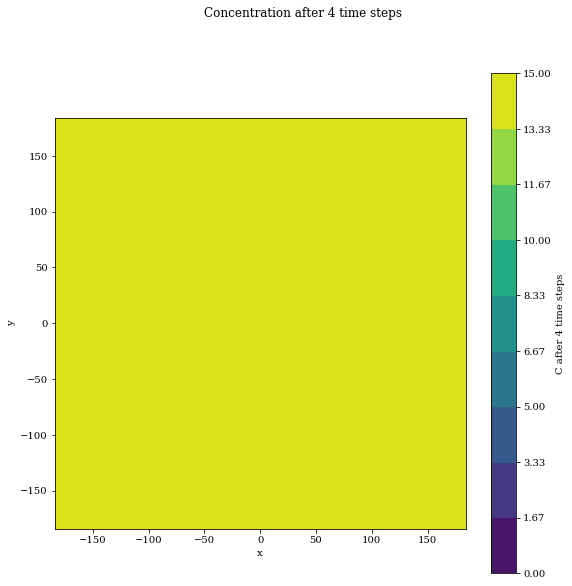

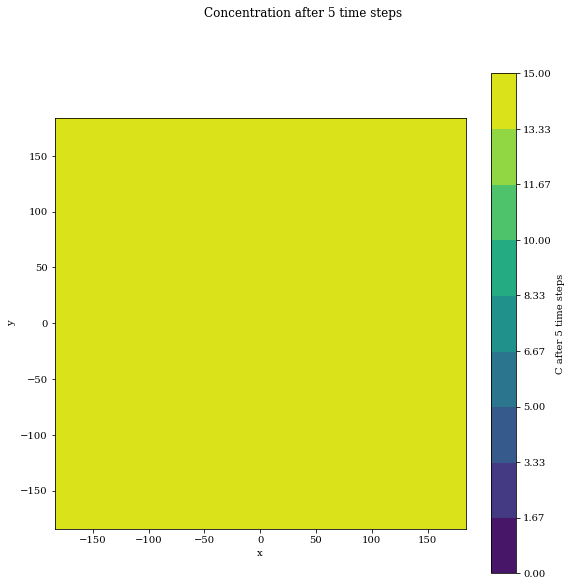

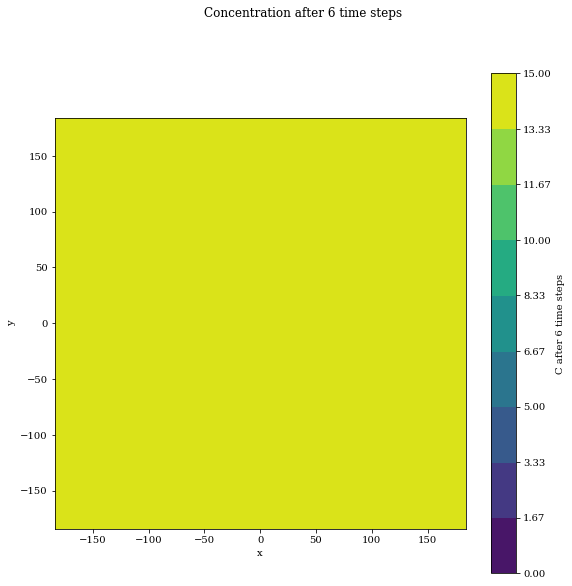

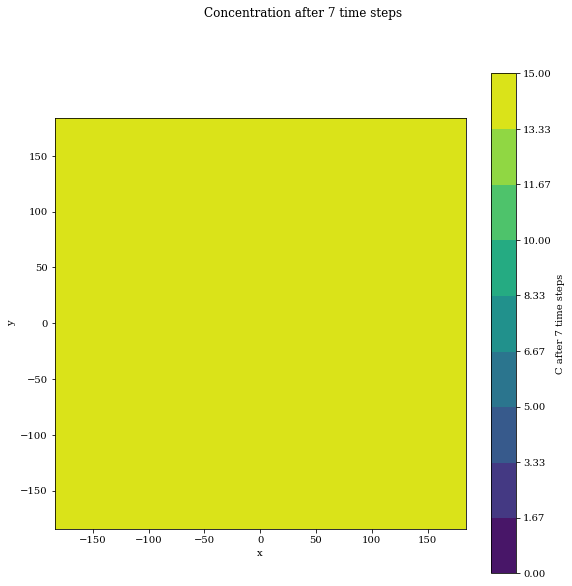

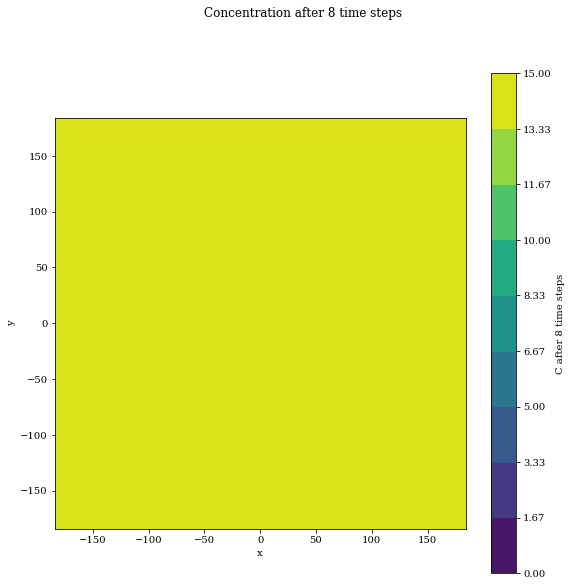

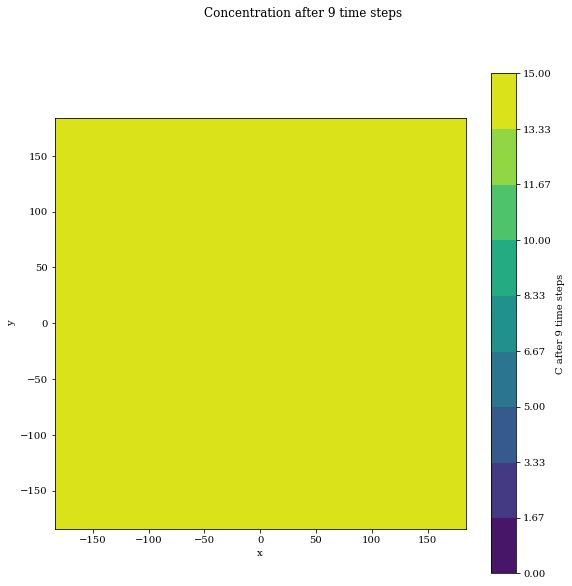

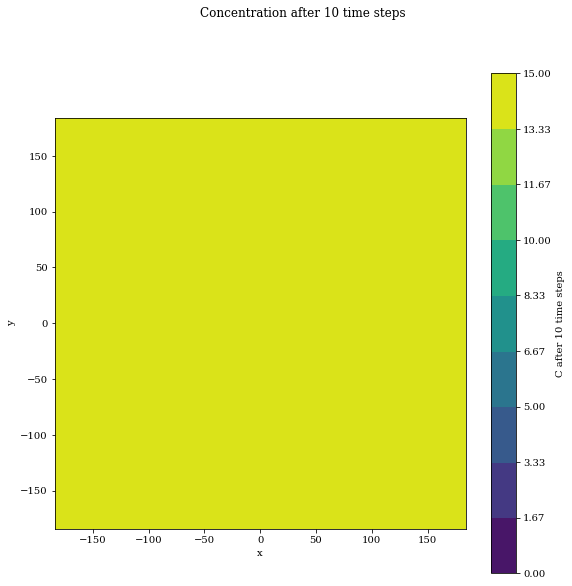

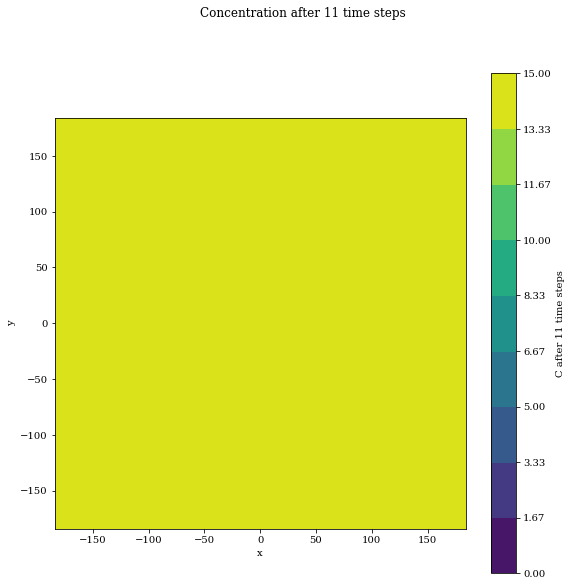

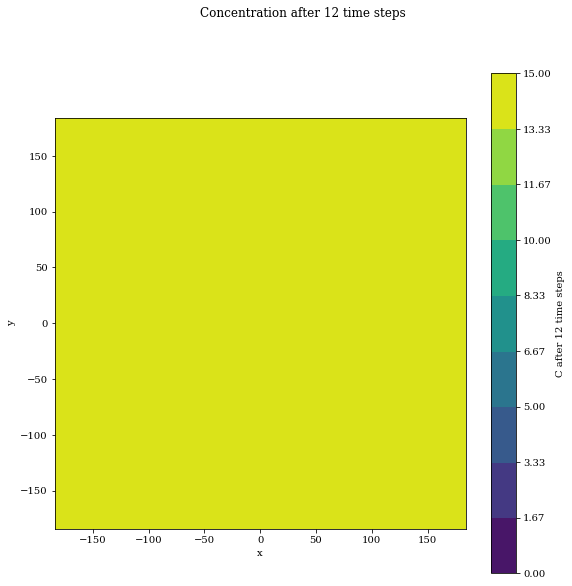

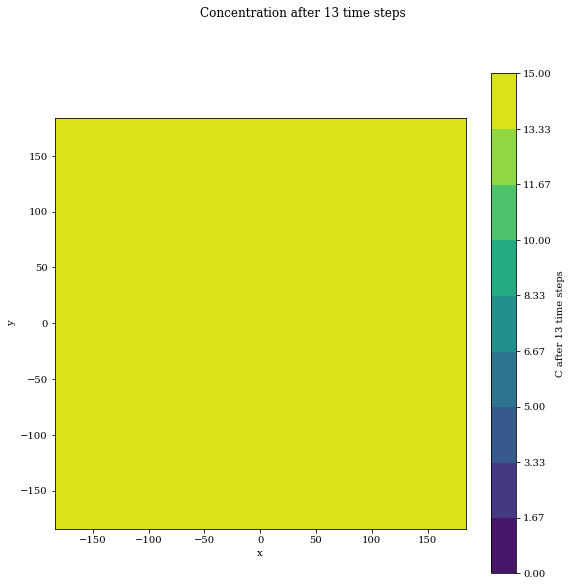

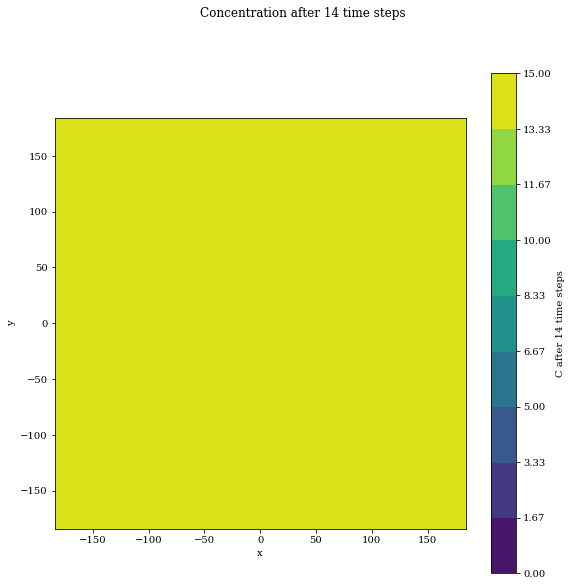

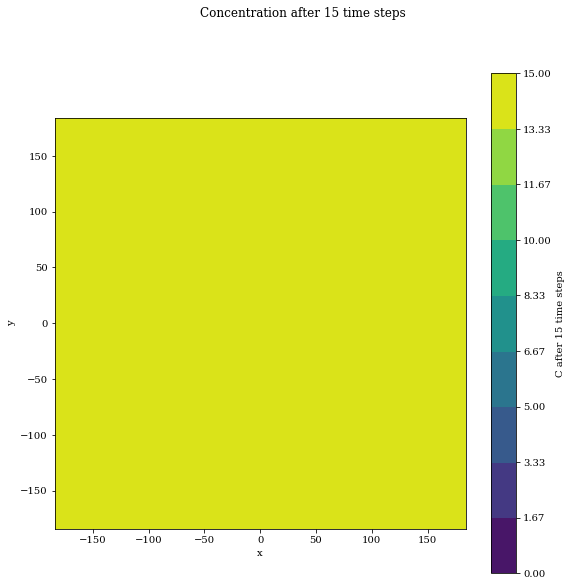

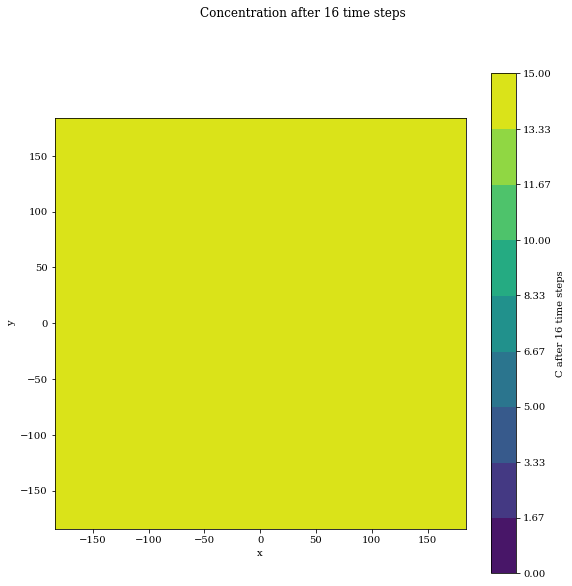

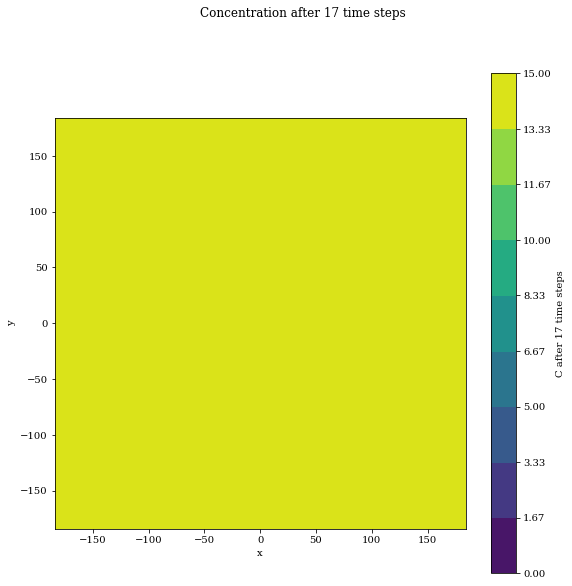

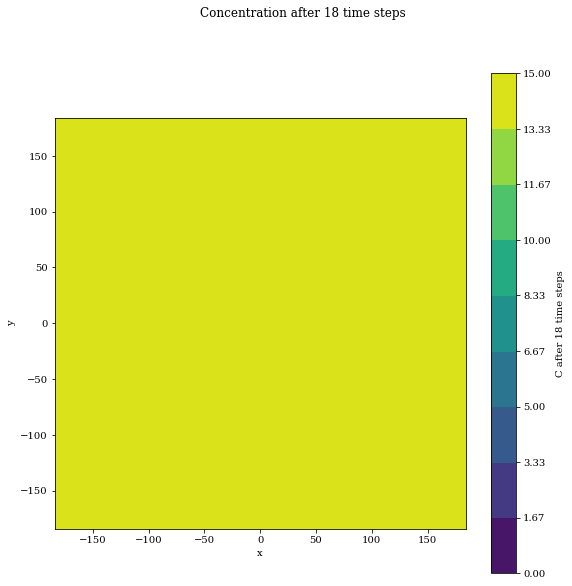

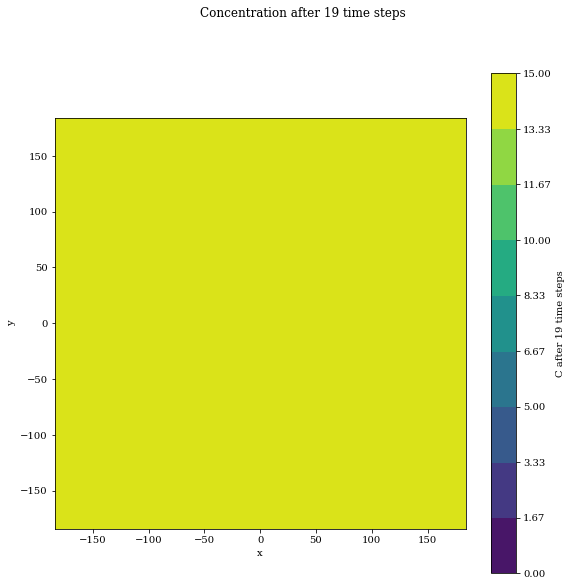

In [14]:
print("Plotting figures for Nutrient Media Concentration")
for i in range(int(nt)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, 15, num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, C_hist[i][:][:], levels=levels)
    fig.suptitle('Concentration after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('C after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;

print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

#pyplot.figure(figsize=(9.2,9.2))
#pyplot.xlabel('x')
#pyplot.ylabel('y')
#levels = np.linspace(0, 100.0, num=51)
#contf = pyplot.contourf(x, y, X2, levels=levels)
#cbar = pyplot.colorbar(contf)
#cbar.set_label('X2 after %nt steps')
#pyplot.axis('scaled', adjustable='box');

Plotting figures for X1 growth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Current time is: Sun Nov  3 15:10:35 2019


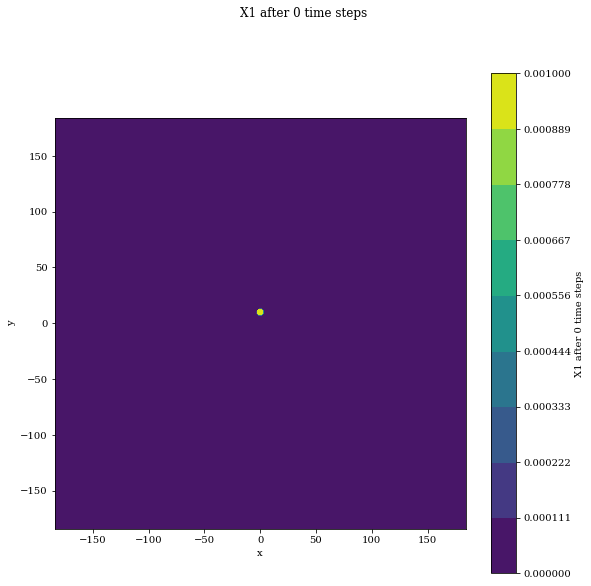

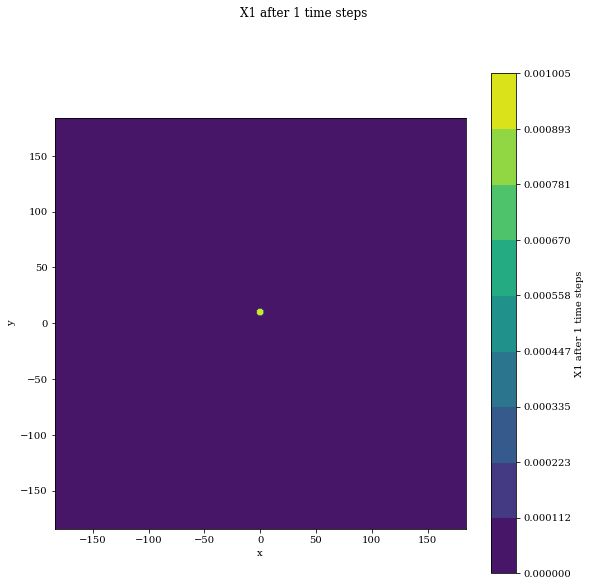

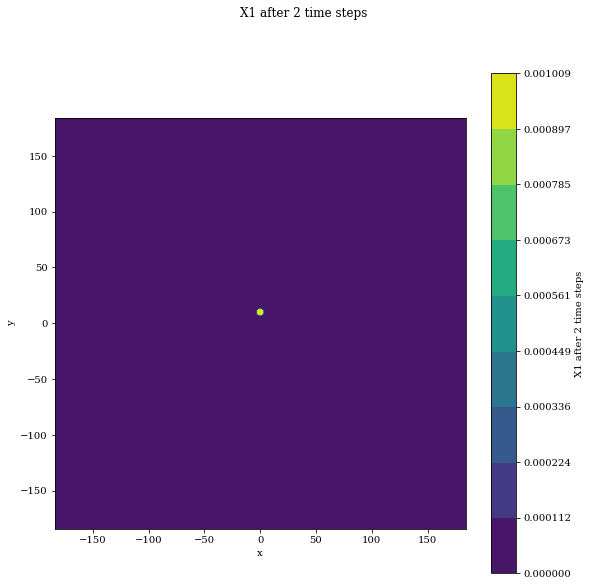

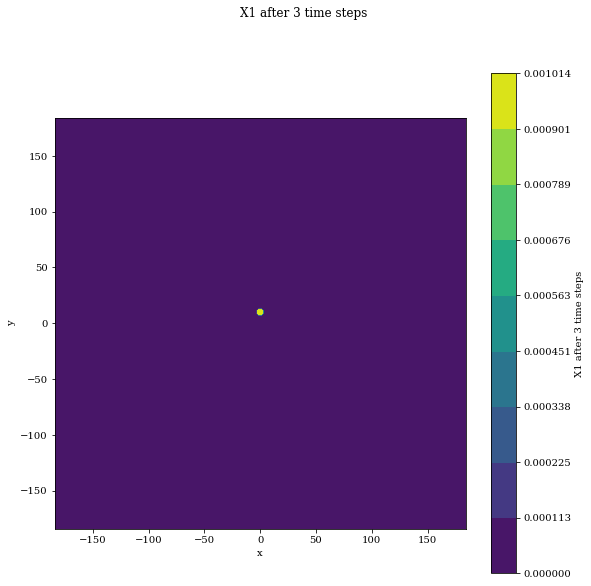

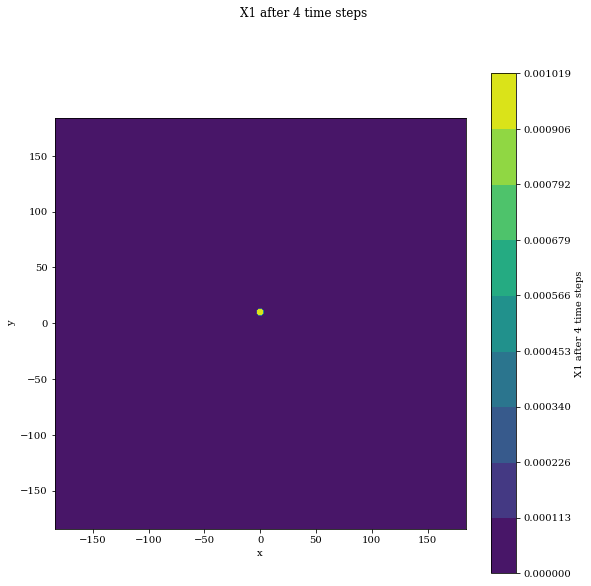

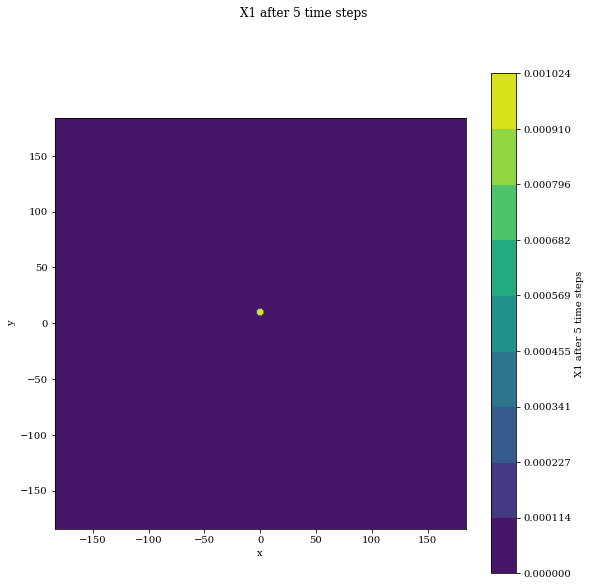

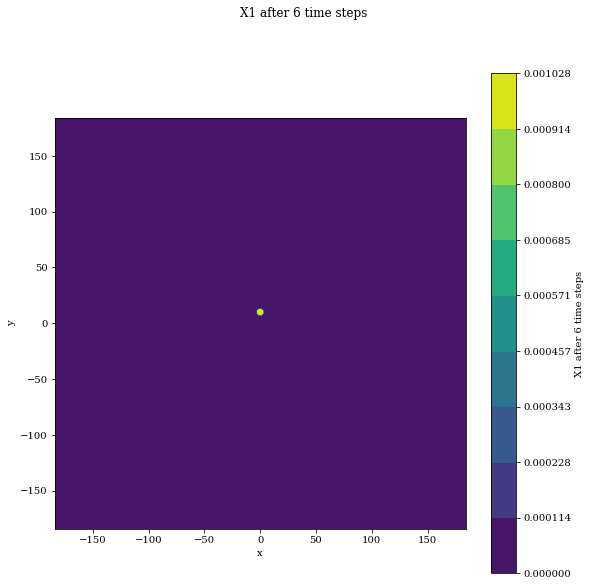

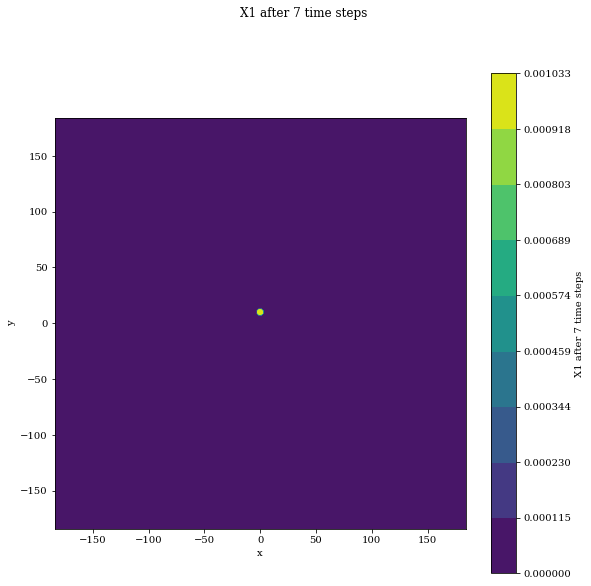

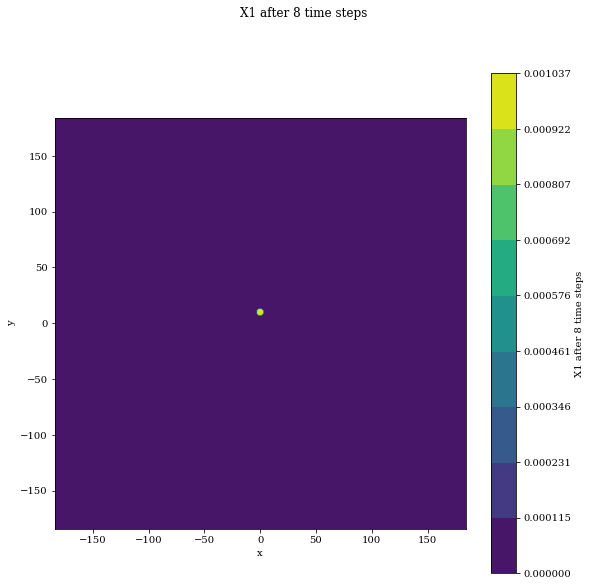

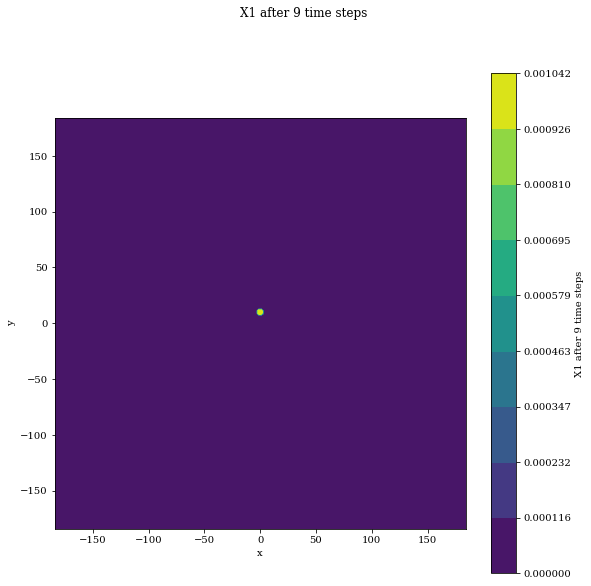

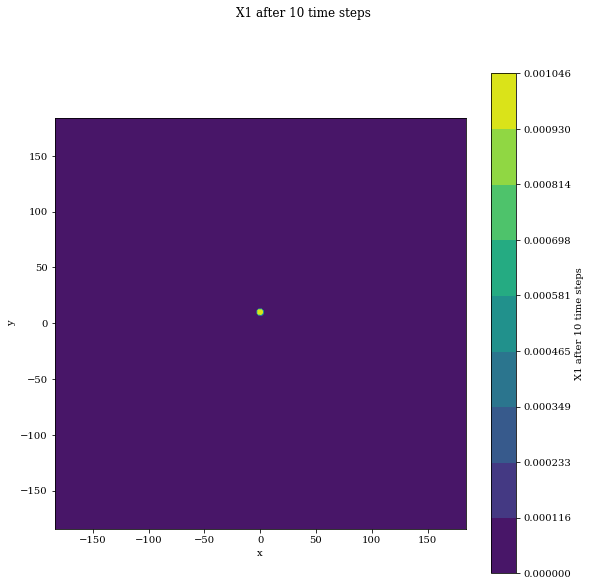

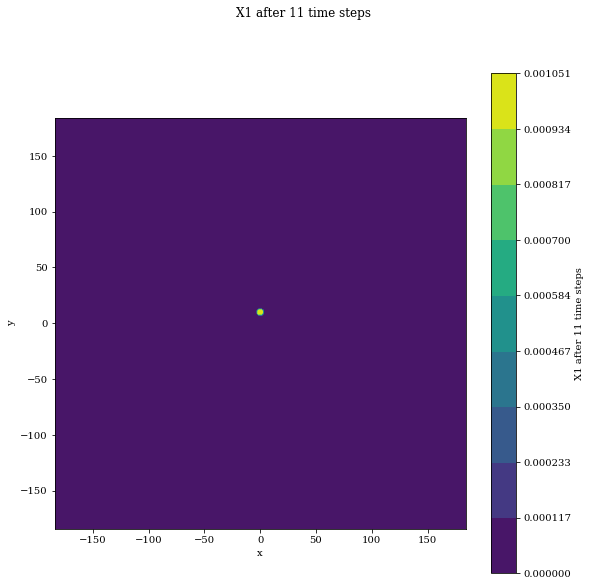

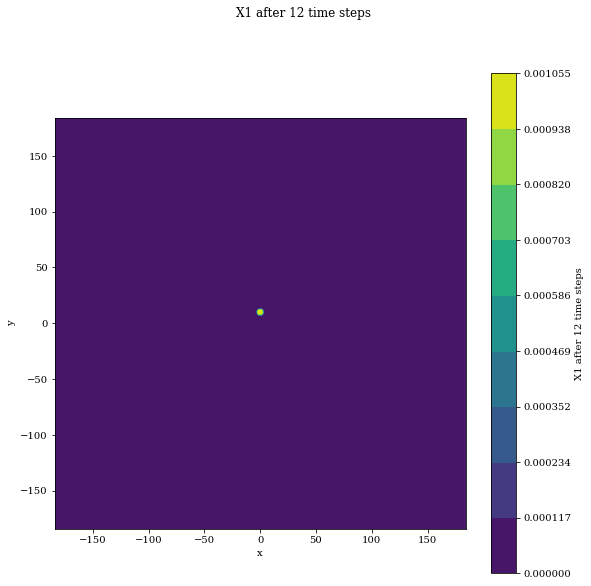

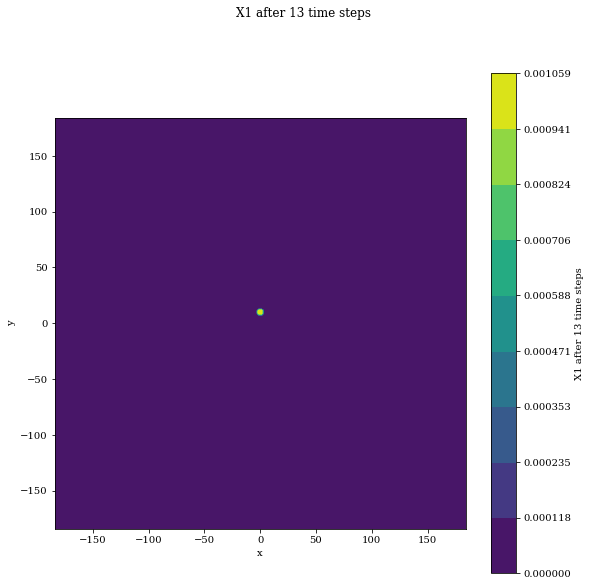

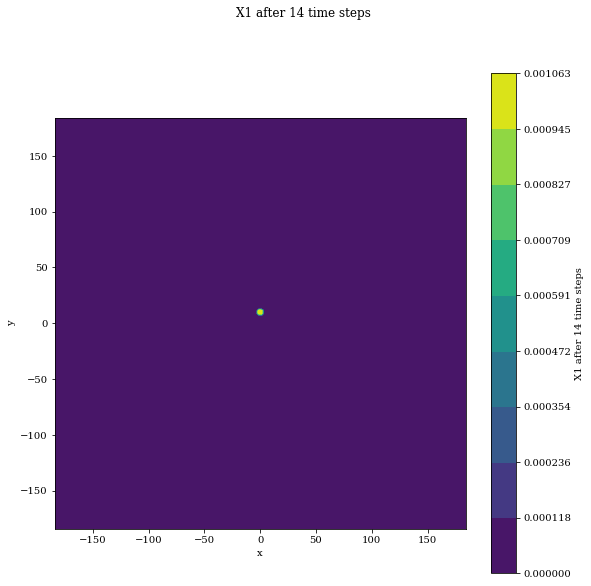

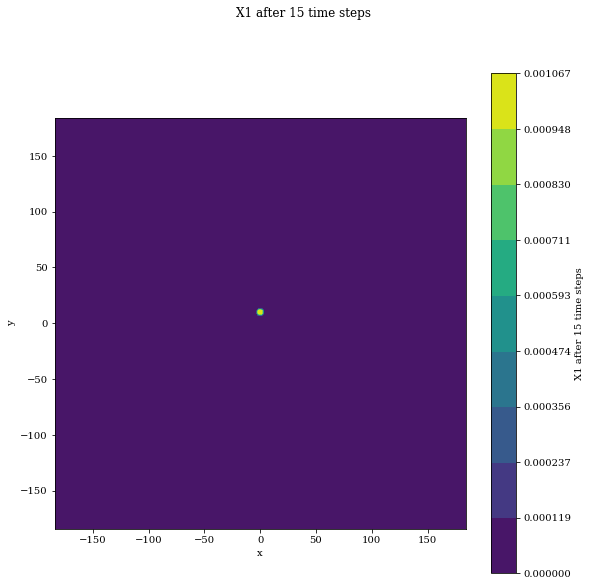

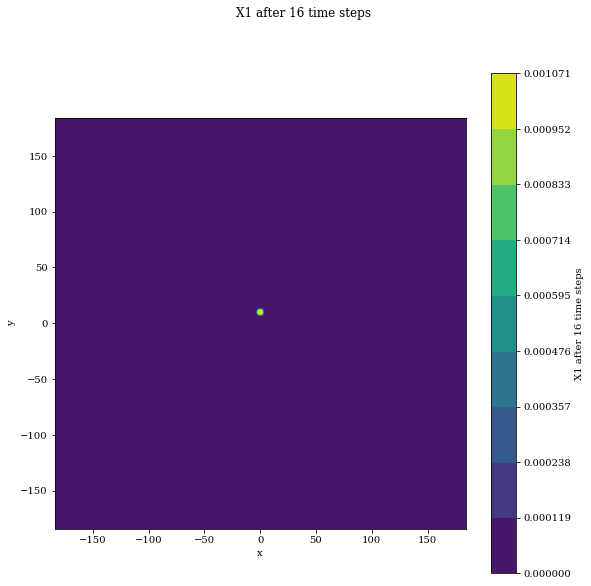

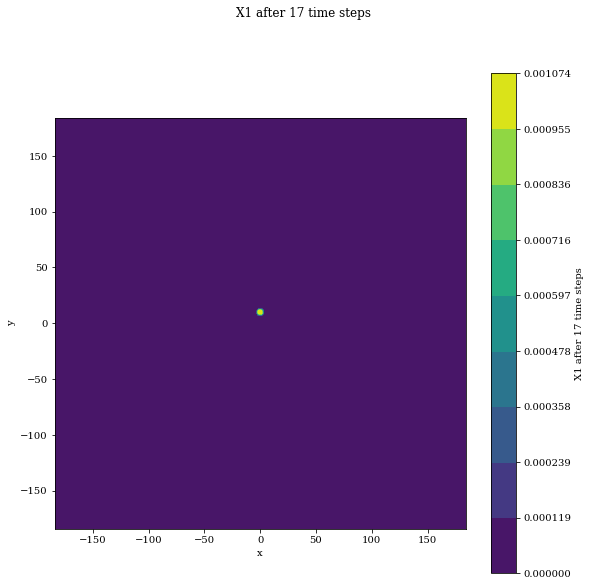

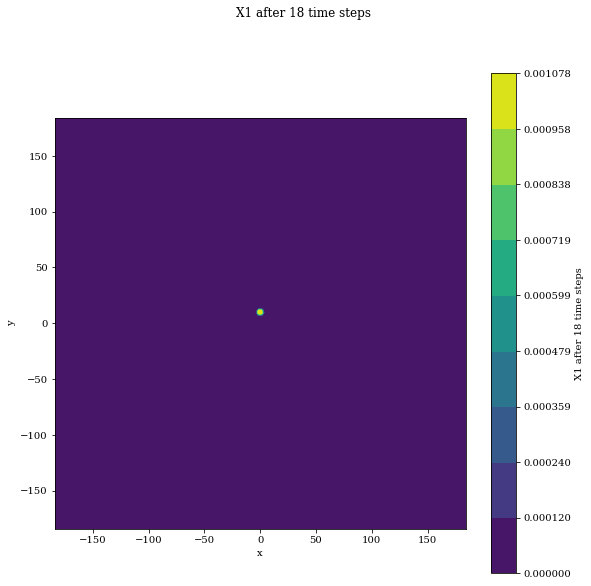

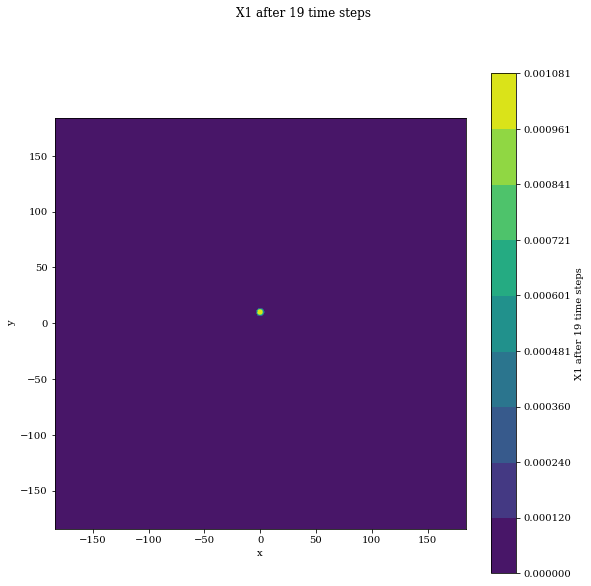

In [15]:
print("Plotting figures for X1 growth")
for i in range(int(nt/1)):
    fig=pyplot.figure(figsize=(9.2,9.2))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X1_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X1_hist[i], levels=levels)
    fig.suptitle('X1 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X1 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))


Plotting figures for X2 growth
0
1
Current time is: Sun Nov  3 15:09:25 2019


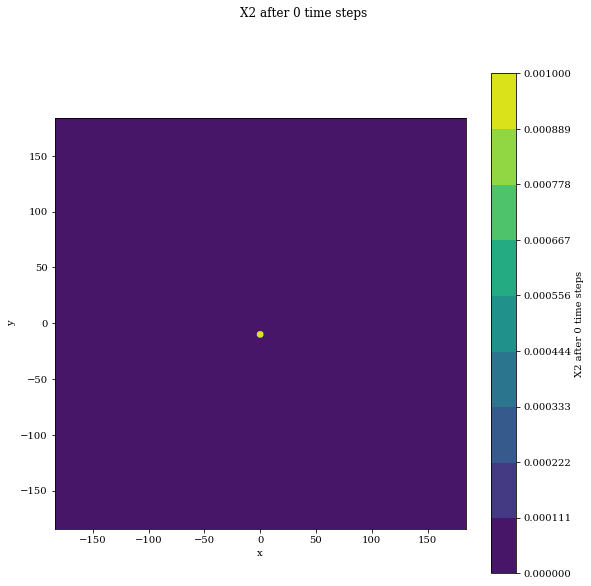

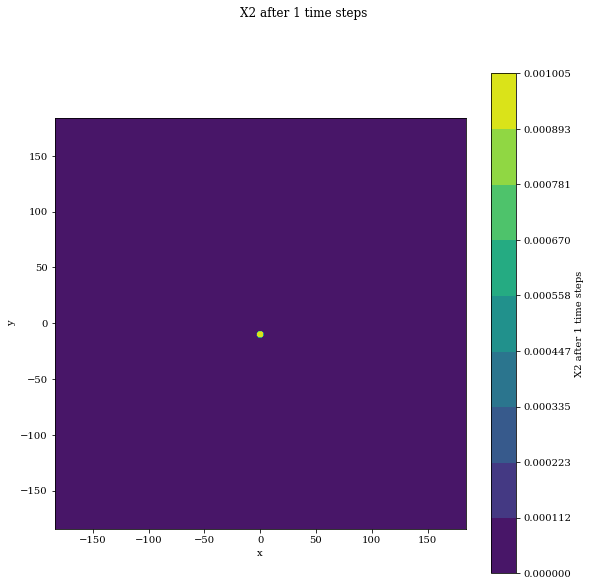

In [7]:
print("Plotting figures for X2 growth")
for i in range(int(nt/10)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    #pyplot.grid()
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X2_hist[i], levels=levels)
    fig.suptitle('X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

In [18]:

############# Animation ################

from matplotlib import animation
from IPython.display import HTML

In [29]:
def update_plot(nt, contf):

#    """
#     Update the line y-data of the Matplotlib figure.
#     
#     Parameters
#     ----------
#     n : integer
#         The time-step index.
#     u_hist : list of numpy.ndarray objects
#         The history of the numerical solution.
#     """
    fig.suptitle('Time step {:0>2}'.format(nt))
    contf.
# 
anim = animation.FuncAnimation(fig, update_plot,frames=nt, fargs=(contf,), interval=300)
# 							   
 	# Display the video.
HTML(anim.to_html5_video())

In [10]:
import winsound
duration = 5000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [11]:
print("Plotting figures for X2 growth")
for i in range(int(nt/500)):
    fig=pyplot.figure(figsize=(9.2,9.2))
    #pyplot.grid()
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    levels = np.linspace(0, np.max(X2_hist[i]), num=10) # the lowest point is being set zero because there is a negative bacterial density coming in picture otherwise
    contf = pyplot.contourf(x, y, X1_hist[i]+X2_hist[i], levels=levels)
    fig.suptitle('X2 after %d time steps' %i)
    cbar = pyplot.colorbar(contf)
    cbar.set_label('X2 after %d time steps' %i)
    print(i)
    pyplot.axis('scaled', adjustable='box')
    ;
print("Current time is: ", end="")
print(time.asctime( time.localtime(time.time())))

Plotting figures for X2 growth
Current time is: Sun Nov  3 15:09:33 2019


In [12]:
np.max(C_hist[5][:][:])

15.0

In [17]:
((C_hist[1])).shape

(369, 369)